## Using dask on a SLURM HPC
This notebook demonstrate how we can run tasks in parallel using dask and SLURM 

### Installing the packages
```
pip install dask
pip install distributed
pip install cloudpickle
```

### Starting the dask cluster. 
There is a good explanation of how this works on [Matthew Rocklin's blog](http://matthewrocklin.com/blog/work/2016/02/26/dask-distributed-part-3). In summary, we need to 

1. start `dask-scheduler` on one machine. This is the node python connects to.
2. start an arbitrary amound of `dask-worker`s on the cluster using SLURM. 

#### 1. Starting `dask-scheduler`
Fairly simple. Open a shell, type `dask-scheduler`, hit Enter. You are good to go. 
You will see something like:

```
distributed.scheduler - INFO - -----------------------------------------------
distributed.scheduler - INFO -   Scheduler at:        10.114.185.14:8786  
distributed.scheduler - INFO -        http at:        10.114.185.14:9786
distributed.bokeh.application - INFO - Web UI: http://10.114.185.14:8787/status/
distributed.scheduler - INFO - -----------------------------------------------
```

You will need the IP and Port listed at *Scheduler at* to connect the workers and to connect from Python. 


####  2. Starting dask-workers.
I prepared a simple shell-script for that. Open a shell, run `./submit-workers.sh <SCHEDULER_HOST> <NUMBER_OF_WORKERS>`. It will submit your workers to slurm. 

**Example**:
In the above case, this would be
```
./submit-workers.sh 10.114.185.14:8786 10
```

**Note**: Each worker already uses 8 threads. The above command would therefore reserve you 80 CPUs. You can adjust that and other options in `./start-worker.sh`. 

## Let's try it

In [1]:
from distributed import Client, progress
from dask.diagnostics import ProgressBar
from dask import delayed
import dask.dataframe as dd
import numpy as np
import dask

In [2]:
c = Client("10.114.185.14:8786")

Dummy function that we want to apply: 

In [3]:
def heavy_stuff(number):
    for i in range(1000000):
        x = number ** number
    return number ** 2

Dummy objects:

In [4]:
objects = [x for x in range(20)]

### Running this locally takes some time: 

In [6]:
[x for x in map(heavy_stuff, objects)]

[0,
 1,
 4,
 9,
 16,
 25,
 36,
 49,
 64,
 81,
 100,
 121,
 144,
 169,
 196,
 225,
 256,
 289,
 324,
 361]

### Running it on the cluster: 

In [7]:
future = c.map(heavy_stuff, objects)

In [8]:
progress(future)

In [9]:
[f.result() for f in future]

[0,
 1,
 4,
 9,
 16,
 25,
 36,
 49,
 64,
 81,
 100,
 121,
 144,
 169,
 196,
 225,
 256,
 289,
 324,
 361]

## Dask provides own Datastructures for parallel Processing 
### Example: Dataframes

In [ ]:
import seaborn as sns
tips = sns.load_dataset("tips")

In [12]:
dd_tips = dd.from_pandas(tips, npartitions=10)

In [13]:
dd_tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [14]:
dd_tips.total_bill.sum().compute()

4827.7699999999995

In [16]:
dd_tips.total_bill.apply(heavy_stuff).compute()

/pstore/home/sturmg/.local/lib/python3.5/site-packages/dask/dataframe/core.py:1757: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


0       288.6601
1       106.9156
2       441.4201
3       560.7424
4       604.6681
5       639.5841
6        76.9129
7       722.5344
8       226.2016
9       218.4484
10      105.4729
11     1243.2676
12      237.7764
13      339.6649
14      219.9289
15      465.6964
16      106.7089
17      265.3641
18      287.9809
19      426.4225
20      321.1264
21      411.6841
22      248.6929
23     1553.9364
24      392.8324
25      317.1961
26      178.7569
27      161.0361
28      470.8900
29      386.1225
         ...    
214     793.5489
215     166.4100
216     792.4225
217     134.3281
218      59.9076
219     908.4196
220     147.8656
221     180.0964
222      73.6164
223     255.3604
224     180.0964
225     264.7129
226     101.8081
227     418.2025
228     176.3584
229     489.2944
230     576.4801
231     246.1761
232     134.7921
233     115.9929
234     241.1809
235     101.4049
236     158.7600
237    1077.8089
238    1283.7889
239     842.7409
240     738.7524
241     513.92

## Build processing Pipelines with `delayed` 

The following code will not run until `compute()` is invoked. 

In [3]:
out = []
for x in range(10):
    a = delayed(np.multiply)(x, 3)
    b = delayed(np.power)(a, 2)
    c = delayed(np.subtract)(b, 4)
    out.append(c)

In [4]:
total = delayed(np.sum)(out)

In [ ]:
total.compute(get=c.get)

Dask can visualize the "compute graph" 

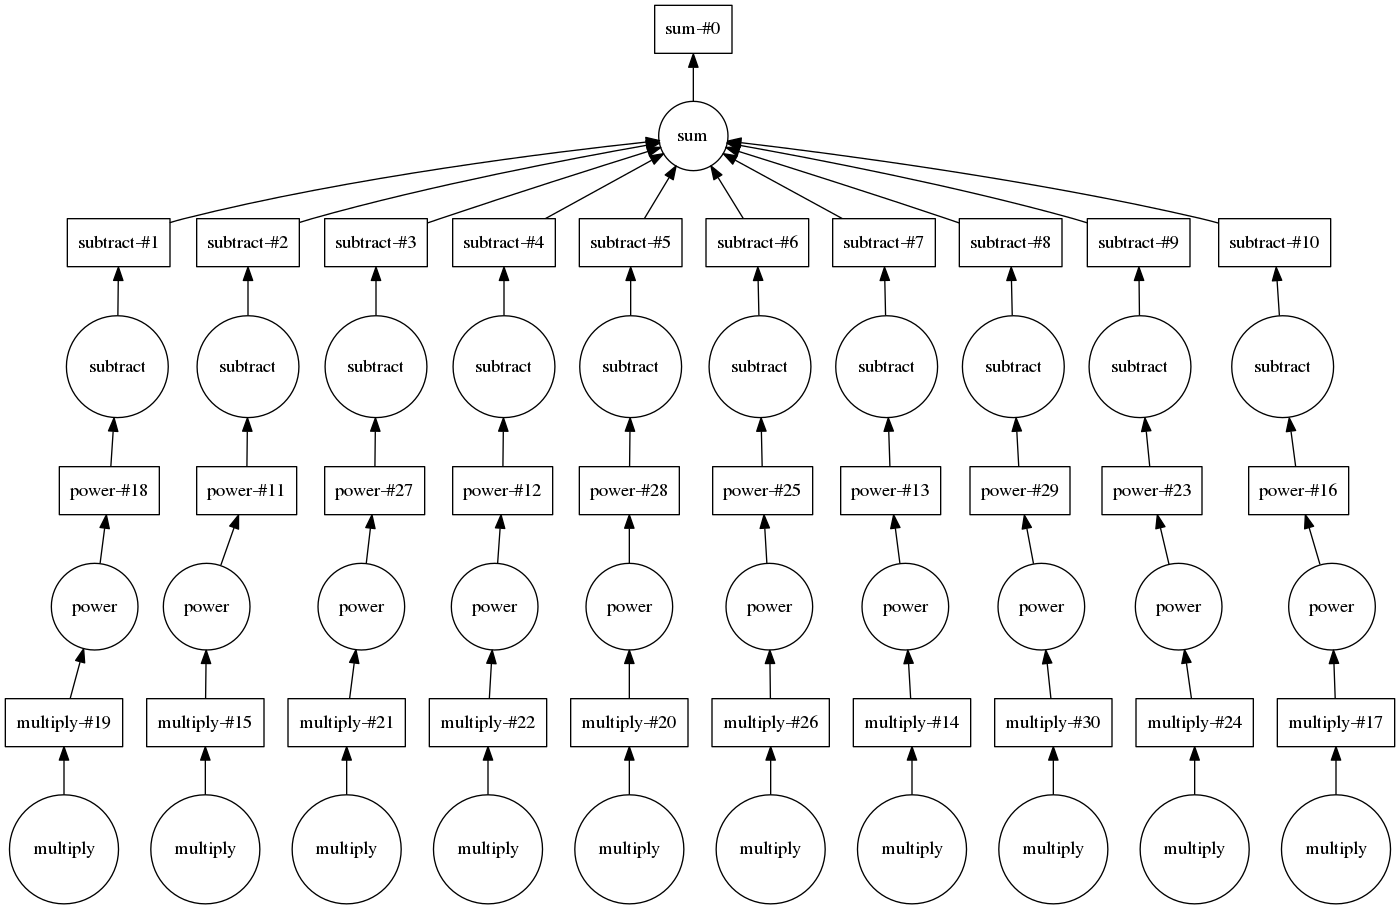

In [5]:
total.visualize()

## Distributing Data
Is it feasible to push a huge object to the workers? 

--> Sometimes the ipython kernel dies unexpectedly. 

In [3]:
huge_dataset = np.random.random_sample((5000, 200000))

In [4]:
out = []
for x in range(10):
    a = delayed(np.multiply)(huge_dataset, 3)
    b = delayed(np.power)(a, 2)
    c = delayed(np.subtract)(b, 4)
    out.append(c)
total = delayed(np.sum)(out)

In [5]:
total

Delayed('sum-79e54cd1-cae7-4bdf-b0cc-901a9b782d22')

In [6]:
c = Client("10.114.185.14:8786")

In [ ]:
total.compute(get=c.get)

### does generating/loading the data on the workers work better? 

In [ ]:
def mk_dataset():
    return np.random.random_sample((5000, 200000))

In [ ]:
out = []
for x in range(10):
    ds = delayed(mk_dataset)()
    a = delayed(np.multiply)(ds, 3)
    b = delayed(np.power)(a, 2)
    c = delayed(np.subtract)(b, 4)
    out.append(c)
total = delayed(np.sum)(out)